1. Environment Configuration and Reproducibility

The computational environment is initialized by capturing system metadata and freezing dependencies to ensure  reproducibility.

In [1]:
import sys
import platform
import subprocess
import numpy as np
import math
import json
import os
import itertools
import matplotlib.pyplot as plt
import pennylane as qml
import scipy
import pandas as pd
from tqdm import tqdm

In [2]:
def get_environment_info():
    """Captures runtime metadata for scientific documentation."""
    return {
        "python_version": sys.version,
        "platform": platform.platform(),
        "numpy_version": np.__version__,
        "scipy_version": scipy.__version__,
        "pennylane_version": qml.__version__
    }

# Generate requirements.txt for environment replication
with open("requirements_benchmark.txt", "w") as f:
    subprocess.run(["pip", "freeze"], stdout=f)

env_info = get_environment_info()
print("--- Runtime Environment Captured ---")
for key, value in env_info.items():
    print(f"{key}: {value}")




--- Runtime Environment Captured ---
python_version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:09:02) [GCC 11.2.0]
platform: Linux-6.1.0-38-amd64-x86_64-with-glibc2.36
numpy_version: 2.4.2
scipy_version: 1.17.0
pennylane_version: 0.44.0


2. TSP Instance Encoding and State Preparation

The valid permutations of cities are calculated and mapped into a Hilbert space. For n cities, starting and ending at city 0, there are M=(n−1)! possible permutations. An amplitude encoding approach is used, where each basis state ∣i⟩ corresponds to a specific valid tour.

    Methodology: Preparation of a uniform superposition state ∣F⟩ over the M valid tours and Definition of a cost vector where costs[idx] represents the total Euclidean distance of that specific permutation.


In [3]:
def get_tsp_instance_data(n_cities, distance_matrix):
    """
    Encodes TSP permutations into quantum state amplitudes and costs.
    
    Returns:
        state_F: The initial uniform superposition state |F>.
        costs: A vector of total distances for each Hamiltonian path.
        n_qubits: Required qubits for the register.
    """
    cities_to_permute = list(range(1, n_cities))
    valid_tours = list(itertools.permutations(cities_to_permute))

    M = len(valid_tours)
    n_qubits = math.ceil(math.log2(M))
    dim = 2 ** n_qubits

    # Initialize uniform superposition over valid tours
    state_F = np.zeros(dim, dtype=complex)
    state_F[:M] = 1.0 / np.sqrt(M)

    # Pre-calculate costs for every possible permutation
    costs = np.zeros(dim)
    for idx, perm in enumerate(valid_tours):
        tour = [0] + list(perm) + [0]
        costs[idx] = sum(
            distance_matrix[tour[i]][tour[i + 1]]
            for i in range(len(tour) - 1)
        )

    return state_F, costs, n_qubits, M

3. The Quantum Circuit

The circuit follows a Trotter-like evolution with two alternating unitaries:

    Phase Oracle (U_cost): Encodes the distances into phases: e^−iγC.

    Mixing Unitary (U_mixer): Grover-like mixer defined by the initial state ∣F⟩, allowing for interference between the encoded paths only.

In [4]:
def make_qnode(n_qubits, p):
    """Defines the PennyLane QNode for the variational quantum circuit."""
    try:
        dev = qml.device("lightning.qubit", wires=n_qubits)
    except Exception:
        dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, diff_method=None)
    def circuit(state_F, costs, params):
        gammas = params[:p]
        betas = params[p:]

        # Step 1: State Preparation
        qml.StatePrep(state_F, wires=range(n_qubits))

        dim = len(costs)
        rho = np.outer(state_F, state_F.conj())
        identity = np.eye(dim, dtype=complex)

        # Step 2: Alternating operator sequences
        for k in range(p):
            # Cost Unitary (Phase Encoding)
            U_cost = np.diag(np.exp(1j * gammas[k] * costs))
            qml.QubitUnitary(U_cost, wires=range(n_qubits))

            # Mixer Unitary (Reflection about |F>)
            U_mixer = identity + (np.exp(-1j * betas[k]) - 1.0) * rho
            qml.QubitUnitary(U_mixer, wires=range(n_qubits))

        return qml.probs(wires=range(n_qubits))

    return circuit

4. Performance Metrics: Solution Quality Error

To quantify the algorithm's performance, the tour lengths between 0 (optimal, l_star) and 1 (worst-case, l_worst) are normalized. The error e_L represents the expected normalized cost of the measured state.

In [5]:
def calculate_error_from_probs(probs, shifted_costs):
    """Computes the expectation value of the normalized cost."""
    return probs[: len(shifted_costs)] @ shifted_costs

In [6]:
def get_target_directory(num_cities):
    """Creates and returns a path to a specific subfolder for the experiment."""
    main_dir = "Benchmark_Results"
    sub_dir = f"N_{num_cities}_Cities"
    full_path = os.path.join(main_dir, sub_dir)

    if not os.path.exists(full_path):
        os.makedirs(full_path)
    return full_path

def save_benchmark_results(filename, df_results, env_info, num_cities):
    """
    Serializes results and metadata into a structured directory.
    """
    # 1. Setup Directory
    target_path = get_target_directory(num_cities)

    # Define file paths inside the target directory
    base_name = os.path.splitext(filename)[0]
    raw_csv_path = os.path.join(target_path, f"{base_name}_raw_instances.csv")
    summary_csv_path = os.path.join(target_path, f"{base_name}_summary_mean.csv")
    json_path = os.path.join(target_path, f"{base_name}_metadata.json")
    npz_path = os.path.join(target_path, filename)

    # 2. Aggregation
    df_summary = df_results.groupby('p')['e_L'].mean().reset_index()

    # 3. Save Files
    df_results.to_csv(raw_csv_path, index=False)
    df_summary.to_csv(summary_csv_path, index=False)

    with open(json_path, "w") as f:
        json.dump(env_info, f, indent=4)

    np.savez_compressed(
        npz_path,
        raw_p=df_results['p'].values,
        raw_e_L=df_results['e_L'].values,
        summary_p=df_summary['p'].values,
        summary_mean_e_L=df_summary['e_L'].values,
        metadata_json=json.dumps(env_info)
    )

    print(f"Archival complete for N={num_cities} in folder: {target_path}")

5. Result Visualization

The plot illustrates the relationship between the circuit depth p and the expected solution error. Theoretically, e_L should decrease as p increases, signifying an improvement in the approximation ratio.

In [7]:
def create_tsp_error_plot(plot_data, num_cities):
    """
    Generates a scientific plot and saves it to the experiment subfolder.
    """
    target_path = get_target_directory(num_cities)
    plot_filename = f"tsp_error_analysis_N{num_cities}.png"
    full_plot_path = os.path.join(target_path, plot_filename)

    depths = np.array(plot_data["depths"])
    avg_errors = np.array(plot_data["avg_errors"])

    fig, ax = plt.subplots(figsize=(10, 5))
    #ax.plot(depths, avg_errors, marker="o", linestyle='-', color='royalblue', linewidth=2)
    ax.plot(depths, avg_errors, marker="o")

    ax.set_xscale("log", base=2)
    ax.set_xticks(depths)
    ax.set_xticklabels(depths.astype(int))
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Solution Quality Error $e_L$")
    ax.set_xlabel("Depth $p$")
    ax.set_title(f"TSP Benchmarking: $N={num_cities}$ Cities")

    #ax.axhline(0.5, linestyle="--", color="gray", alpha=0.5, label="Random Baseline")
    ax.axhline(0.5, linestyle="--", color="black")
    ax.grid(axis="y", linestyle="--", alpha=0.4)

    #table_data = [[int(d), f"{e:.4f}"] for d, e in zip(depths, avg_errors)]
    #the_table = ax.table(cellText=table_data, colLabels=["Depth $p$", "Mean $e_L$"], loc='right', cellLoc='center', bbox=[1.15, 0.2, 0.4, 0.6])
    #the_table.auto_set_font_size(False)
    #the_table.set_fontsize(10)
    #the_table.scale(1.2, 1.2)

    #plt.subplots_adjust(right=0.7)

    plt.savefig(full_plot_path, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"Plot saved to: {full_plot_path}")
    plt.show()

6. Benchmark Execution

The benchmark is executed over a range of circuit depths p ∈ [2,4,8,16,32] using pre-generated TSP instances. To isolate the effect of circuit depth, we use fixed parameter scheduling for gamma and beta.

Loading Dataset: Generated_datasets/tsp_benchmark_7_cities_seed_42.npz
Successfully loaded 200 instances.

Caching Instances...


Precomputing instances: 100%|██████████| 200/200 [00:00<00:00, 550.54it/s]



Instances cached!

Starting Benchmark...


Instances processed (p=2): 100%|██████████| 200/200 [00:04<00:00, 48.53it/s]


p=2: mean e_L = 0.544187


Instances processed (p=4): 100%|██████████| 200/200 [00:07<00:00, 26.23it/s]


p=4: mean e_L = 0.431684


Instances processed (p=8): 100%|██████████| 200/200 [00:15<00:00, 12.84it/s]


p=8: mean e_L = 0.320231


Instances processed (p=16): 100%|██████████| 200/200 [00:27<00:00,  7.14it/s]


p=16: mean e_L = 0.223103


Instances processed (p=32): 100%|██████████| 200/200 [00:59<00:00,  3.37it/s]


p=32: mean e_L = 0.156987
Archival complete for N=7 in folder: Benchmark_Results/N_7_Cities
Plot saved to: Benchmark_Results/N_7_Cities/tsp_error_analysis_N7.png


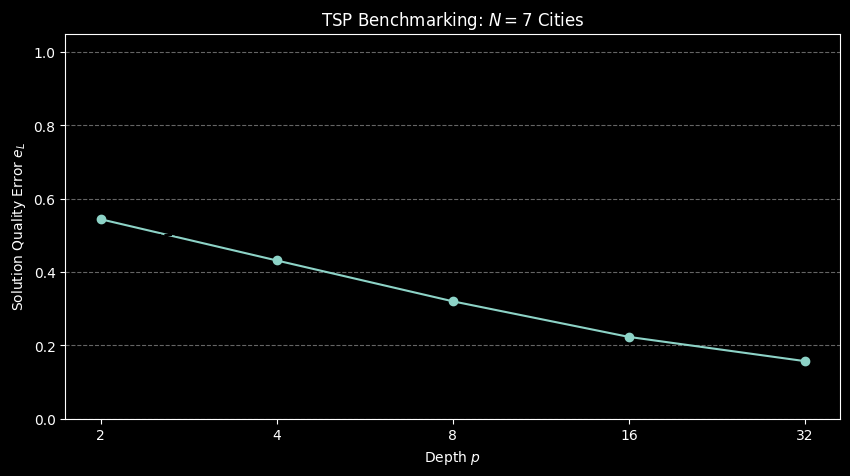


Benchmark completed!


In [8]:
if __name__ == "__main__":
    num_cities = 7
    seed = 42
    depths = [2, 4, 8, 16, 32]

    input_file = f"tsp_benchmark_{num_cities}_cities_seed_{seed}.npz"
    input_path = os.path.join("Generated_datasets", input_file)

    plot_data = {"depths": [], "avg_errors": []}
    all_e_L_results = []

    print(f"Loading Dataset: {input_path}")
    if not os.path.exists(input_path):
        raise FileNotFoundError(f"The file {input_path} does not exist. "
                                f"Please run the generation script first!")

    try:
        loaded_data = np.load(input_path, allow_pickle=True)
        dist_matrices = loaded_data['distances']
        l_stars = loaded_data['l_stars']
        l_worsts = loaded_data['l_worsts']

        # Define n_instances here
        n_instances = len(dist_matrices)
        print(f"Successfully loaded {n_instances} instances.")

    except Exception as e:
        print(f"An unexpected error occurred while loading: {e}")
        # Raising an error stops the cell execution in Jupyter
        raise

    # Precomputation for Efficiency
    print("\nCaching Instances...")
    instance_cache = []
    for i in tqdm(range(n_instances), desc="Precomputing instances"):
        D = dist_matrices[i]
        state_F, costs, n_qubits, M = get_tsp_instance_data(num_cities, D)

        # Cost normalization (Min-Max scaling)
        shifted_costs = (costs[:M] - l_stars[i]) / (l_worsts[i] - l_stars[i])

        instance_cache.append({
            "state_F": state_F,
            "costs": costs,
            "shifted_costs": shifted_costs,
            "n_qubits": n_qubits
        })
    print("\nInstances cached!")

    # Main Benchmarking Loop
    print("\nStarting Benchmark...")
    for p in depths:
        errors = []
        # Linear Parameter Schedule
        k_vals = np.arange(p)
        gammas = k_vals / (p - 1)
        betas = 1.0 - k_vals / (p - 1)
        fixed_params = np.concatenate([gammas, betas])

        # Instantiate QNode for specific qubit requirement
        circuit = make_qnode(instance_cache[0]["n_qubits"], p)

        for idx, data in enumerate(tqdm(
            instance_cache,
            desc=f"Instances processed (p={p})"
        )):
            probs = circuit(
                data["state_F"],
                data["costs"],
                fixed_params
            )

            e_L = calculate_error_from_probs(
                probs,
                data["shifted_costs"]
            )
            errors.append(e_L)

            all_e_L_results.append({
                "instance_index": idx,
                "p": p,
                "e_L": e_L
            })

        avg_error = np.mean(errors)
        plot_data["depths"].append(p)
        plot_data["avg_errors"].append(avg_error)

        print(f"p={p}: mean e_L = {avg_error:.6f}")

    df_results = pd.DataFrame(all_e_L_results)

    results_filename = f"QAOA_FixedParams_N{num_cities}.npz"
    save_benchmark_results(results_filename, df_results, env_info, num_cities)

    create_tsp_error_plot(plot_data, num_cities)

    print("\nBenchmark completed!")